In [2]:
# import numpy as np
# import matplotlib.pyplot as plt
import torch
# from networks import DiffusionNetwork
# from data import LatinHyperCubeSampling
# from networks import BaseNetwork

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
data=np.load(r'E:\Heat_diffusion_laser_metadata\30_Sep_2025_06_30_29_FBH13mm_step_size_sim_step_0_002m_p1.npz',allow_pickle=True)

In [3]:
data['meta']

array([['laser_power', '6.839999999999999'],
       ['T1', '5'],
       ['T2', '5'],
       ['T3', '400'],
       ['method', 'simulation'],
       ['fps', '50.0'],
       ['height', '240'],
       ['width', '320'],
       ['sequence_length', '410'],
       ['working_distance', '172.0'],
       ['pos_X', '135.0'],
       ['pos_Y', '135.0'],
       ['point_no', '1'],
       ['points_in_series', '225'],
       ['thickness', '3.5'],
       ['thickness_meters', '0.0035'],
       ['size_X', '28.0'],
       ['size_Y', '28.0'],
       ['comments', 'simulation'],
       ['time', '30/09/2025 06:30:40'],
       ['sample_size_x', '0.3'],
       ['sample_size_y', '0.3'],
       ['offset_X_start_point', '134.99999999999997'],
       ['offset_Y_start_point', '134.99999999999997'],
       ['offset_X_end_point', '136.0'],
       ['offset_Y_end_point', '136.0'],
       ['distance_X', '2.0'],
       ['distance_Y', '2.0'],
       ['no_of_points_X', '15'],
       ['no_of_points_Y', '15'],
       ['IFOV', '

Density: 1600 kg/m3 <br><br>
Specific heat capacity: 700 J/Kg*K <br><br>
Thermal conductivity kxx: 2.23 W/m*K<br><br>
Thermal conductivity kyy: 1.95 W/m*K<br><br>
Thermal conductivity kzz: 0.93 W/m*K

In [4]:
data=np.array(data['data'],dtype=np.float32)

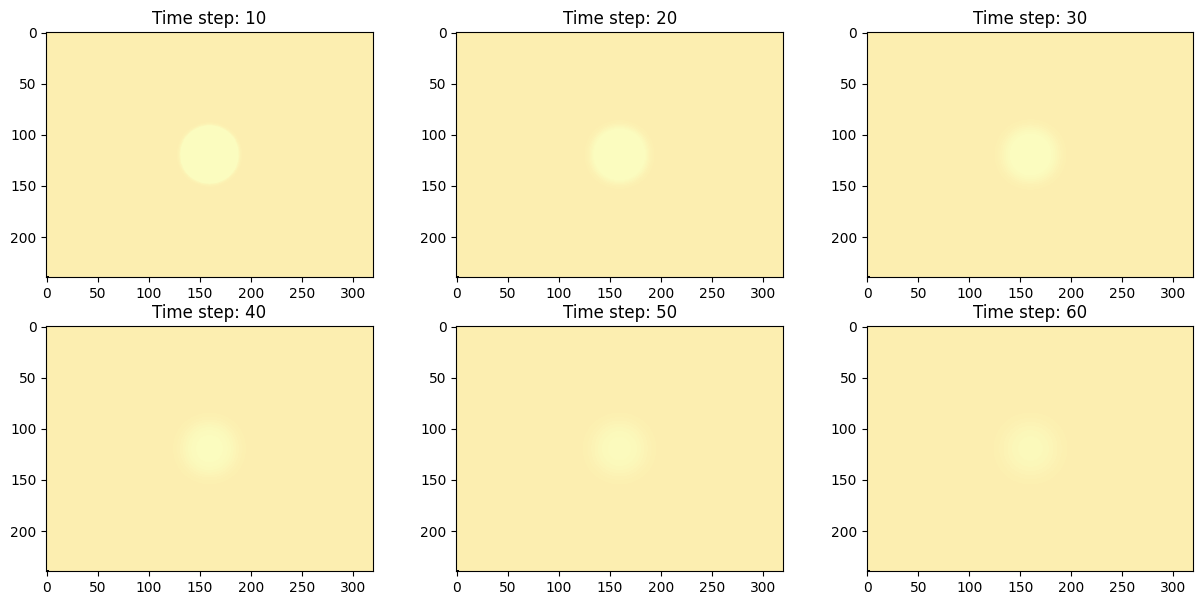

In [5]:
plt.figure(figsize=(15,7))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.title(f'Time step: {i*10+10}')
    plt.imshow(data[i*10+10,:,:],cmap='magma',vmin=10000,vmax=30000)


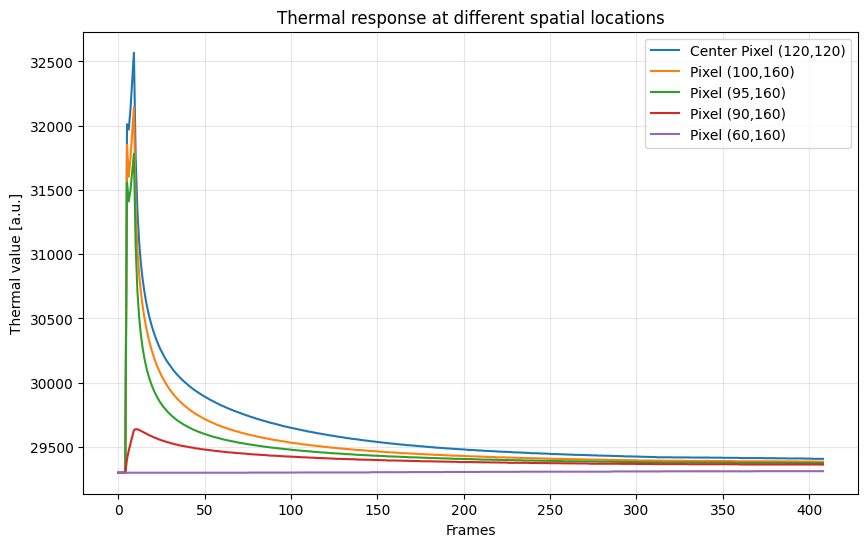

In [7]:
plt.figure(figsize=(10,6))
plt.plot(data[:,120,160],label='Center Pixel (120,120)')
plt.plot(data[:,100,160],label='Pixel (100,160)')
plt.plot(data[:,95,160],label='Pixel (95,160)')
plt.plot(data[:,90,160],label='Pixel (90,160)')
plt.plot(data[:,60,160],label='Pixel (60,160)')
plt.grid(alpha=0.3)
plt.xlabel('Frames')
plt.ylabel('Thermal value [a.u.]')
plt.title('Thermal response at different spatial locations')
plt.legend()

In [8]:
data.shape

(409, 240, 320)

In [9]:
sampler=LatinHyperCubeSampling(data.shape) # (T,H,W)
coordis=sampler.lhs_tensor_indices(100,mode='boundary') # Collocation points

In [10]:
# inputs
X = torch.from_numpy(data[:, :-1].astype(np.float32))
X.requires_grad_(True)  # enable gradient tracking for PINN residuals

# targets
y = torch.from_numpy(data[:, -1].astype(np.float32))

In [11]:
X=torch.rand((10,3),requires_grad=True)

y=torch.rand(10).view(-1,1)
y.size()

torch.Size([10, 1])

In [12]:
X.size()

torch.Size([10, 3])

In [13]:
model=BaseNetwork(input_size=3,output_size=1,hidden_layers=2,hidden_units=50)

In [14]:
result=model(X)

In [15]:
result.size()

torch.Size([10, 1])

In [16]:
grad_u = torch.autograd.grad(
    outputs=result,
    inputs=X,
    grad_outputs=torch.ones_like(result),
    create_graph=True
)[0]

In [17]:
grad_u

tensor([[ 0.2943,  0.2323, -0.1144],
        [ 0.3085,  0.2077, -0.1191],
        [ 0.3090,  0.2155, -0.0913],
        [ 0.2899,  0.2235, -0.1241],
        [ 0.2977,  0.2180, -0.0901],
        [ 0.2757,  0.2131, -0.1323],
        [ 0.3301,  0.2366, -0.0953],
        [ 0.3237,  0.2336, -0.0994],
        [ 0.3163,  0.2189, -0.1020],
        [ 0.2682,  0.2180, -0.1288]], grad_fn=<MmBackward0>)

In [18]:
grad_u[:, 0]

tensor([0.2943, 0.3085, 0.3090, 0.2899, 0.2977, 0.2757, 0.3301, 0.3237, 0.3163,
        0.2682], grad_fn=<SelectBackward0>)

In [19]:
grad2_u_x = torch.autograd.grad(
    outputs=grad_u,      # derivative w.r.t t,x and y
    inputs=X,
    grad_outputs=torch.ones_like(grad_u),
    create_graph=True
)[0]

In [20]:
grad2_u_x.size()

torch.Size([10, 3])

In [21]:
model=DiffusionNetwork(input_size=3,output_size=1,hidden_layers=8,hidden_units=30,hidden_units_grad2=20)

In [22]:
model.a_x

Parameter containing:
tensor([2.2121], requires_grad=True)

In [23]:
temps,approx=model(X)

In [25]:
X.size()

torch.Size([10, 3])

In [24]:
temps.size()

torch.Size([10, 1])

In [26]:
approx.size()

torch.Size([10, 1])

In [27]:
approx[:,0]

tensor([-0.0969,  0.0425, -0.0662,  0.2062,  0.0497,  0.0502,  0.0944,  0.0824,
         0.1030,  0.1251], grad_fn=<SelectBackward0>)